# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Exploratory Data Analysis

### Portfolio data set

In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [7]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [8]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


The portfolio data set contains a single column called "channels", which contains a list of different mediums through which the offer can be viewed. This is best split into multiple columns, with each channel containing a 1 or a 0 to indicate if it was used in the associated offer or not.

In [9]:
def f(channel_str, row):
    return 1 if channel_str in row else 0

In [10]:
channels_list = ['email', 'mobile', 'social', 'web']

for i in channels_list:
    portfolio[i] = portfolio['channels'].apply(lambda x: f(i, x))

In [11]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


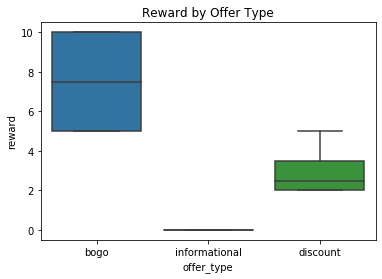

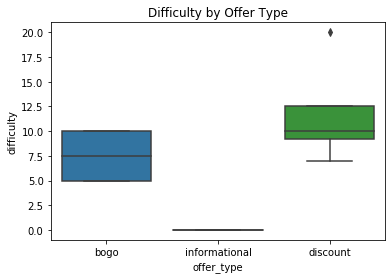

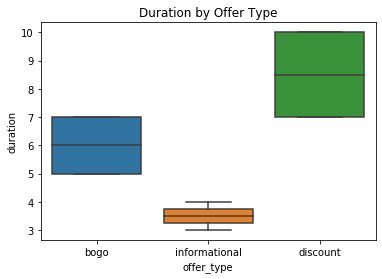

In [12]:
num_cols = ['reward', 'difficulty', 'duration']

for col in num_cols:
    sns.boxplot(data=portfolio, x='offer_type', y=col)
    plt.title(f'{col.capitalize()} by Offer Type')
    plt.show()

See what percentage of offers appeared on each channel, broken out by offer type

In [13]:
offer_counts = portfolio['offer_type'].value_counts().to_dict()

In [14]:
channel_groups = portfolio.groupby(['offer_type']).agg({'web':'sum', 
                                       'email':'sum', 
                                       'mobile': 'sum', 
                                       'social':'sum'}).reset_index()

In [15]:
channel_groups['counts'] = portfolio['offer_type'].map(offer_counts)

In [16]:
channel_groups = channel_groups.assign(web=channel_groups.web / channel_groups.counts * 100,
                      email=channel_groups.email / channel_groups.counts * 100,
                      mobile=channel_groups.mobile / channel_groups.counts * 100,
                      social=channel_groups.social / channel_groups.counts * 100)

In [17]:
channel_groups

,offer_type,web,email,mobile,social,counts
0,bogo,75.0,100.0,100.0,75.0,4
1,discount,100.0,100.0,75.0,50.0,4
2,informational,50.0,100.0,100.0,50.0,2


Text(0, 0.5, 'Percentage')

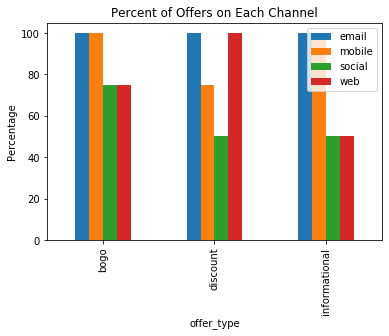

In [18]:
channel_groups.plot(x='offer_type', y=channels_list, kind='bar')
plt.title('Percent of Offers on Each Channel')
plt.ylabel('Percentage')

BOGO makes use of the most channels for its offers, with 100% of offers appearing on both email and mobile, and 75% appearing on social and web. Both Discount and Informational offers use social media less frequently.

### Profile data set

In [19]:
profile.shape

(17000, 5)

In [20]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [21]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [22]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Looks like gender and income both have the same amount of nulls. We will have to check to see if they are the same rows

In [23]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


There is a weird outlier of age==118. As it is unlikely that 118-year olds are using the Starbucks app, we will have to investigate further.

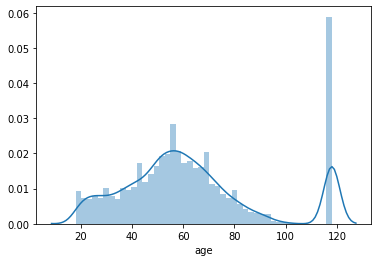

In [24]:
sns.distplot(profile['age'])

In [25]:
profile[profile['age']==118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

Looks like there are many rows with 118, but 118 appears to be the only major outlier in the age column. The number of rows with age 118 equals the number of rows with nulls for the gender and income columns. If these rows are all the same, we can toss them out.

In [26]:
bad_data = profile[profile['gender'].isnull()]

In [27]:
# All the null gender and income columns are contained in the same rows
bad_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            0 non-null      object 
 1   age               2175 non-null   int64  
 2   id                2175 non-null   object 
 3   became_member_on  2175 non-null   int64  
 4   income            0 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


/Users/alysonweidmann/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


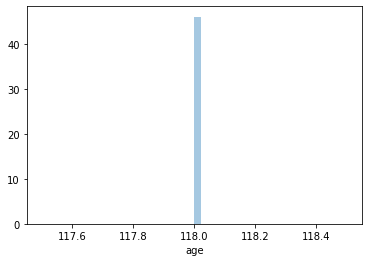

In [28]:
# All the rows with outlier age of 118 are also contained in this data set.
sns.distplot(bad_data['age'])

As there are 2175 rows with unusable data (i.e., unreasonable age, unknown gender and income), we can assume this data can be safely discarded from the dataset 

In [29]:
profile = profile[~profile.index.isin(bad_data.index)]

In [30]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [31]:
profile.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


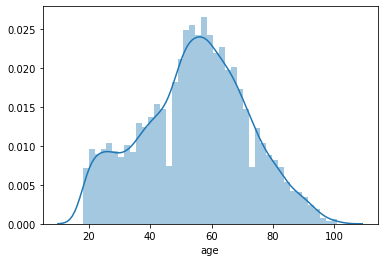

In [32]:
sns.distplot(profile['age'])

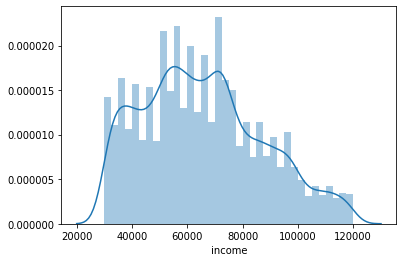

In [33]:
sns.distplot(profile['income'])

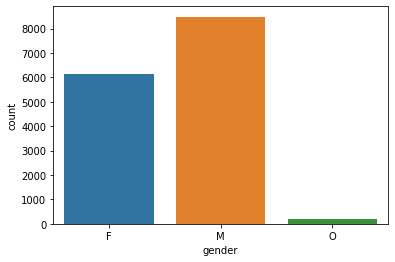

In [34]:
sns.countplot(profile['gender'])

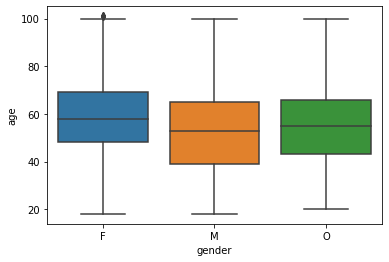

In [35]:
sns.boxplot(profile['gender'], profile['age'])

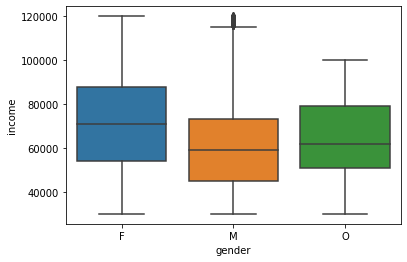

In [36]:
sns.boxplot(profile['gender'], profile['income'])

As a final piece of cleaning for the profile data set, we need to adjust the became_member_on field from scientific notation to datetime. 

In [37]:
pd.to_datetime(profile['became_member_on'])

1       1970-01-01 00:00:00.020170715
3       1970-01-01 00:00:00.020170509
5       1970-01-01 00:00:00.020180426
8       1970-01-01 00:00:00.020180209
12      1970-01-01 00:00:00.020171111
                     ...             
16995   1970-01-01 00:00:00.020180604
16996   1970-01-01 00:00:00.020180713
16997   1970-01-01 00:00:00.020170126
16998   1970-01-01 00:00:00.020160307
16999   1970-01-01 00:00:00.020170722
Name: became_member_on, Length: 14825, dtype: datetime64[ns]

It looks like just using the pd.to_datetime method to convert the became_member_on field converts all dates to 1/1/1970. We can see from looking at the original data that the dates are in a datekey format (YYYYMMDD), and that the 1970 date from the to_datetime() method is incorrect. We will use the datetime library to convert the datekey to a date format

In [38]:
print(profile['became_member_on'])

1        20170715
3        20170509
5        20180426
8        20180209
12       20171111
           ...   
16995    20180604
16996    20180713
16997    20170126
16998    20160307
16999    20170722
Name: became_member_on, Length: 14825, dtype: int64


In [39]:
from datetime import datetime

In [40]:
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: 
                                                               datetime.strptime(str(x), '%Y%m%d'
                                                                                ).strftime('%m/%d/%Y')
                                                               )

In [41]:
profile.head(10)

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,07/15/2017,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,05/09/2017,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,04/26/2018,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,02/09/2018,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,11/11/2017,51000.0
13,F,61,aa4862eba776480b8bb9c68455b8c2e1,09/11/2017,57000.0
14,M,26,e12aeaf2d47d42479ea1c4ac3d8286c6,02/13/2014,46000.0
15,F,62,31dda685af34476cad5bc968bdb01c53,02/11/2016,71000.0
16,M,49,62cf5e10845442329191fc246e7bcea3,11/13/2014,52000.0
18,M,57,6445de3b47274c759400cd68131d91b4,12/31/2017,42000.0


Let's engineer some additional time-based features based on when each customer became a Starbucks member. There may be some seasonality here that could be useful down the line in our model

In [42]:
profile['became_member_month'] = profile['became_member_on'].apply(lambda x: 
                                                                   datetime.strptime(x, '%m/%d/%Y').strftime('%b')
                                                                  )

profile['became_member_year'] = profile['became_member_on'].apply(lambda x: 
                                                                   datetime.strptime(x, '%m/%d/%Y').strftime('%Y')
                                                                  )

In [43]:
profile.head(10)

,gender,age,id,became_member_on,income,became_member_month,became_member_year
1,F,55,0610b486422d4921ae7d2bf64640c50b,07/15/2017,112000.0,Jul,2017
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,05/09/2017,100000.0,May,2017
5,M,68,e2127556f4f64592b11af22de27a7932,04/26/2018,70000.0,Apr,2018
8,M,65,389bc3fa690240e798340f5a15918d5c,02/09/2018,53000.0,Feb,2018
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,11/11/2017,51000.0,Nov,2017
13,F,61,aa4862eba776480b8bb9c68455b8c2e1,09/11/2017,57000.0,Sep,2017
14,M,26,e12aeaf2d47d42479ea1c4ac3d8286c6,02/13/2014,46000.0,Feb,2014
15,F,62,31dda685af34476cad5bc968bdb01c53,02/11/2016,71000.0,Feb,2016
16,M,49,62cf5e10845442329191fc246e7bcea3,11/13/2014,52000.0,Nov,2014
18,M,57,6445de3b47274c759400cd68131d91b4,12/31/2017,42000.0,Dec,2017


In [44]:
signups = profile.groupby(['became_member_month']).size().to_frame('member_signups').reset_index()

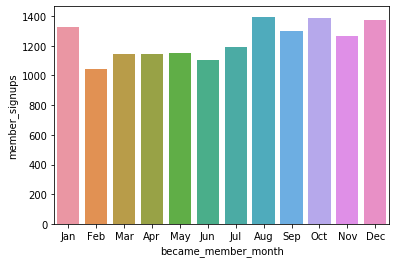

In [45]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.barplot(data=signups, x='became_member_month', y='member_signups', order=month_order)

Looks like membership signups pick up in late summer/fall and are higher throughout the winter.

### Transcript data set

In [46]:
transcript.shape

(306534, 4)

In [47]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [48]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [49]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

There are no nulls in the data set, so we don't have to worry about cleaning them.

In [50]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


There is only one numerical feature in the transcript data set, 'time'. Let's check the distribution of values to see if there are any outliers.

Text(0.5, 1.0, 'Distribution of ')

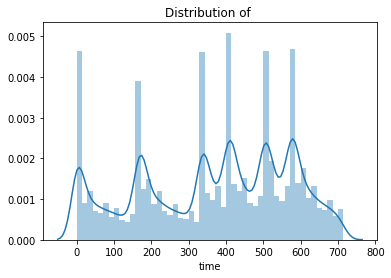

In [51]:
sns.distplot(transcript['time'])
plt.title('Distribution of ')

We want to do some initial cleaning of this data set before joining it to the other two for feature engineering. Namely, the "value" column contains a dictionary that contains information we want to link the transcript data to our other data sources. We want to take the dictionary values and convert them to their own columns for easier cleaning

In [52]:
# view the 'value' dataset
transcript['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [53]:
df = pd.json_normalize(transcript['value'])

In [54]:
df.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [55]:
df['offer_id_new'] = np.where(df['offer id'].isnull() \
                              & df['offer_id'].notnull(), df['offer_id'],df['offer id'])

In [56]:
# drop old id columns and rename the clean one
df.drop(['offer id', 'offer_id'], axis=1, inplace=True)
df.rename(columns={'offer_id_new': 'offer_id'}, inplace=True)

In [57]:
# merge the new value df with the original transcript data
transcript = transcript.merge(df, how='inner', left_index=True, right_index=True)

In [58]:
transcript.drop(columns='value', inplace=True)

In [59]:
# replace null values with 0
transcript['amount'].fillna(0, inplace=True)
transcript['reward'].fillna(0, inplace=True)

In [60]:
# check data is clean
transcript.head()

,person,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0


Now we can do a bit more visualization of the transcript data set

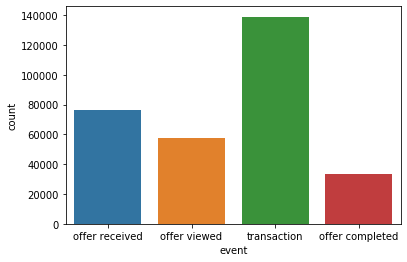

In [61]:
sns.countplot(transcript['event'])

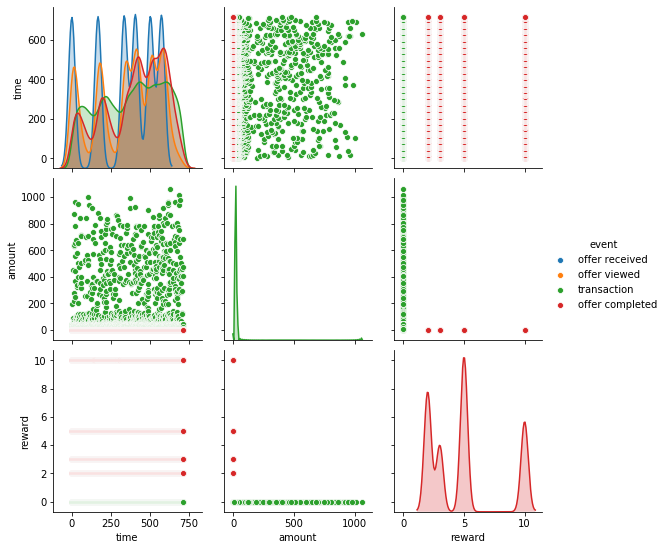

In [62]:
import warnings
warnings.filterwarnings('ignore')
sns.pairplot(transcript, hue='event')

From the pairplot we can see that the majority of the 'amount' values correspond to transactions and the 'reward' values correspond to offers completed

### Joining the 3 datasets
Now we will join the profile, portfolio, and transcript datasets to explore in more detail the relationships between these datasets. 

The transcript dataset contains both the customer ID ('person') and the offer ID ('offer ID). We will use the person field to join transcript to profile, and the offer ID field to join transcript to portfolio, creating a new dataframe called 'data'

In [63]:
# rename ID columns in profile and portfolio for easier joining
profile.rename(columns={'id':'person'}, inplace=True)
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [64]:
transcript.rename(columns={'reward':'received_reward'}, inplace=True)
portfolio.rename(columns={'reward':'offer_reward'}, inplace=True)

In [65]:
data = pd.merge(transcript, profile, how='left', on='person')
data = pd.merge(data, portfolio, how='left', on='offer_id')

In [66]:
data.head()

,person,event,time,amount,received_reward,offer_id,gender,age,became_member_on,income,...,became_member_year,offer_reward,channels,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,05/09/2017,100000.0,...,2017,5.0,"[web, email, mobile]",5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,...,NaN,5.0,"[web, email]",20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5,M,68.0,04/26/2018,70000.0,...,2018,2.0,"[web, email, mobile]",10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,...,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,...,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [67]:
offer_groups = data.groupby(['offer_type','event'])['person'].size().reset_index()

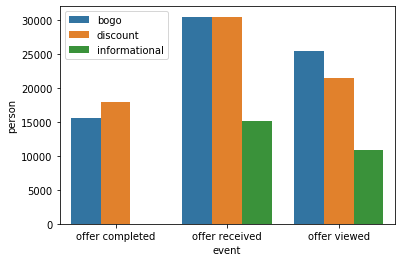

In [68]:
sns.barplot(data=offer_groups, x='event', y='person', hue='offer_type')
plt.legend(loc='upper left')

Discount offers do a little better at converting than BOGO. Makes intuitive sense, as a person might not necessarily need 2 coffees if they weren't going to even buy one in the first place, but a person might buy one coffee for a discount

In [69]:
data.groupby(['offer_type']).agg({'received_reward':['sum', 'mean', 'min', 'max']})

received_reward                     
                          sum      mean  min   max
offer_type                                        
bogo                 113440.0  1.583981  0.0  10.0
discount              51236.0  0.733011  0.0   5.0
informational             0.0  0.000000  0.0   0.0

BOGO rewards are worth more money generally, although they convert less frequently.

In [70]:
data.groupby(['offer_type']).agg({'offer_reward':['sum', 'mean', 'min', 'max']})

offer_reward                     
                       sum      mean  min   max
offer_type                                     
bogo              539505.0  7.533197  5.0  10.0
discount          201188.0  2.878308  2.0   5.0
informational          0.0  0.000000  0.0   0.0

In [71]:
media_groups = data.groupby(['offer_type','event']).agg({'web':'sum', 
                                                         'mobile':'sum', 
                                                         'social':'sum', 
                                                         'email':'sum'}).reset_index()

In [72]:
media_groups

,offer_type,event,web,mobile,social,email
0,bogo,offer completed,11981.0,15669.0,11315.0,15669.0
1,bogo,offer received,22841.0,30499.0,22822.0,30499.0
2,bogo,offer viewed,18733.0,25449.0,21278.0,25449.0
3,discount,offer completed,17910.0,14490.0,10473.0,17910.0
4,discount,offer received,30543.0,22875.0,15243.0,30543.0
5,discount,offer viewed,21445.0,18782.0,14664.0,21445.0
6,informational,offer received,7617.0,15235.0,7618.0,15235.0
7,informational,offer viewed,4144.0,10831.0,6687.0,10831.0


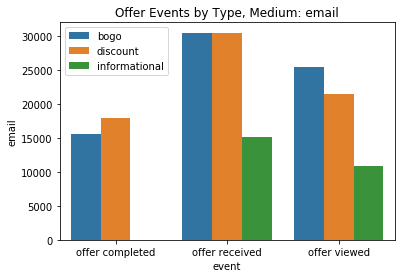

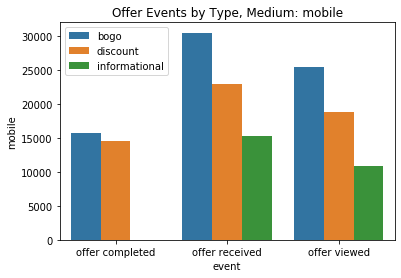

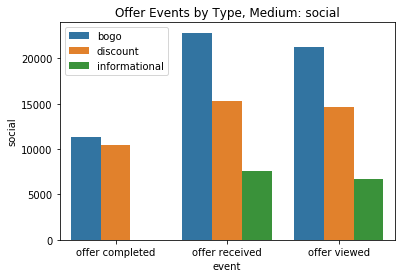

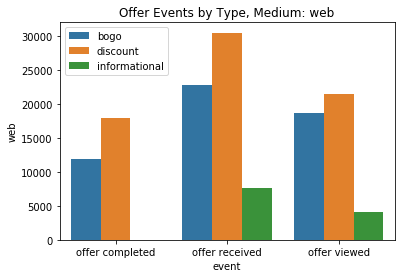

In [73]:
for i in channels_list:
    sns.barplot(data=media_groups, x='event', y=i, hue='offer_type')
    plt.legend(loc='upper left')
    plt.title(f'Offer Events by Type, Medium: {i}')
    plt.show()

In [74]:
customer_groups = data.groupby(['offer_type','event']).agg({'age':'median' , 
                                                            'income':'median'
                                                           }).reset_index()

In [75]:
customer_groups

,offer_type,event,age,income
0,bogo,offer completed,57.0,70000.0
1,bogo,offer received,55.0,64000.0
2,bogo,offer viewed,55.0,64000.0
3,discount,offer completed,56.0,68000.0
4,discount,offer received,55.0,64000.0
5,discount,offer viewed,56.0,65000.0
6,informational,offer received,55.0,63000.0
7,informational,offer viewed,55.0,64000.0


Not a ton of differences in offer completions by type when broken down by age and income. In general, higher incomes translate to more completions and a slightly higher likelihood of viewing an offer that is received

In [76]:
customer_groups_gender = data.groupby(['offer_type',
                                       'event',
                                       'gender'])['person'].count().to_frame('Counts').reset_index()

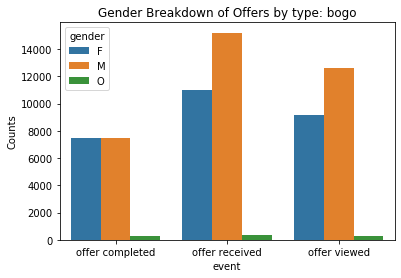

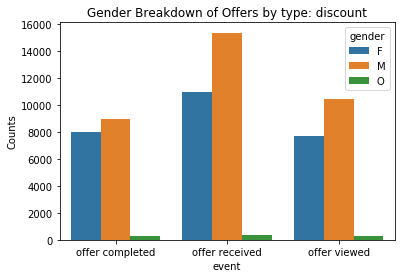

In [77]:
offer_types = ['bogo', 'discount']
for i in offer_types:
    temp_data = customer_groups_gender[customer_groups_gender['offer_type']==i]
    sns.barplot(data=temp_data,
                x='event',
                y='Counts',
                hue='gender')
    plt.title(f'Gender Breakdown of Offers by type: {i}')
    plt.show()

Women more likely than men to complete an offer if they view it

In [78]:
data.groupby(['offer_type','event']).agg({'difficulty':['min', 'max', 'mean', 'median']})

difficulty                        
                                     min   max       mean median
offer_type    event                                             
bogo          offer completed        5.0  10.0   7.239773    5.0
              offer received         5.0  10.0   7.500246   10.0
              offer viewed           5.0  10.0   7.753350   10.0
discount      offer completed        7.0  20.0  11.045896   10.0
              offer received         7.0  20.0  11.759552   10.0
              offer viewed           7.0  20.0  10.215388   10.0
informational offer received         0.0   0.0   0.000000    0.0
              offer viewed           0.0   0.0   0.000000    0.0

Discount offers not only complete more frequently, but they require a higher customer spend generally. 

# Data Preprocessing and Feature Engineering
Now that we've explored the data and it is mostly clean, we begin to preprocess our data for modeling. 

Our data can generally be divided into 3 groups:
* People who receive and view an offer and effectively complete it ('offer completed')
* People who receive/view an offer but do not complete it ('offer received', 'offer viewed')
* People who complete a transaction irrespective of whether they received or viewed an offer ('transaction')

To begin, we should further clean our data set to separate out customers who completed a purchase that was not tied to a promotional offer, as they can inflate our dataset with false negatives -- i.e., there is no way to know if these users would have completed an offer if one were received, and so we have incomplete information about these samples with respect to the target variable ('offer completed')

By sorting the data by person and time, we can see that each stage in the offer process exists as its own row. There is a separate row for offer received, viewed, whether a transaction was completed after viewing an offer, and whether the offer itself was completed at the same time. Currently, the only way to tie these events to a single sequence of events is to look at the 'time' column along with the 'offer_id' column:

In [79]:
# sort data by person, in chronological order of events
data.sort_values(['person', 'time'], inplace=True)

In [80]:
# get the event immediately preceding the current one, grouped by user
person_groups = data.groupby('person')['event'].shift(1).to_frame()

In [81]:
data['prior_event'] = person_groups['event']

In [82]:
#view the data to make sure it is correct
data[['person','event', 'prior_event', 'time']].head(50)

,person,event,prior_event,time
55972,0009655768c64bdeb2e877511632db8f,offer received,NaN,168
77705,0009655768c64bdeb2e877511632db8f,offer viewed,offer received,192
89291,0009655768c64bdeb2e877511632db8f,transaction,offer viewed,228
113605,0009655768c64bdeb2e877511632db8f,offer received,transaction,336
139992,0009655768c64bdeb2e877511632db8f,offer viewed,offer received,372
153401,0009655768c64bdeb2e877511632db8f,offer received,offer viewed,408
168412,0009655768c64bdeb2e877511632db8f,transaction,offer received,414
168413,0009655768c64bdeb2e877511632db8f,offer completed,transaction,414
187554,0009655768c64bdeb2e877511632db8f,offer viewed,offer completed,456
204340,0009655768c64bdeb2e877511632db8f,offer received,offer viewed,504


We created a new helper column to view the event that immediately preceded the event of the current row. So if a transaction was associated with an offer, the 'prior_event' would be 'offer viewed' or 'offer received', while the event would be 'transaction'. If a transaction occurred independent of an offer, the prior event would be 'transaction' or 'offer completed' (from the previous offer) or NaN (if transaction is the first event recorded for a user)

Now we can use this information to filter out transactions that occur without offers

In [83]:
# get rows where transactions not tied to offers
transactions_only = data[(data['event']=='transaction') \
                         & (data['prior_event'].isin(['transaction', 'completed', None]))]

In [84]:
#remove transactions not tied to offers from the data set
data = data[~data.index.isin(transactions_only.index)]

In [85]:
data.shape

(249948, 22)

Now that the only transactions in our data set are tied to offers, we can link those rows to the offers by filling down the offer_id

In [86]:
data['offer_id'] = data['offer_id'].ffill()

In [87]:
data['offer_id'].isnull().sum()

0

In [88]:
data[['difficulty', 
      'duration', 
      'offer_reward',
      'offer_type', 
      'email', 
      'mobile', 
      'social', 
      'web']] = data[['difficulty', 'duration','offer_reward', 'offer_type', 'email', 'mobile', 'social', 'web']].ffill()

In [89]:
data[['person', 'offer_id', 'event', 'time']].head(50)

,person,offer_id,event,time
55972,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer received,168
77705,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer viewed,192
89291,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,transaction,228
113605,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer received,336
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer viewed,372
153401,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer received,408
168412,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,transaction,414
168413,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer completed,414
187554,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer viewed,456
204340,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,offer received,504


Now, we likely only need one row per unique person/offer combo; otherwise there will be a lot of duplicate information in our features that could bias the model in some way. We ultimately want to filter our data set to identify the terminal end state of the offers -- if an offer was completed, we want to keep those rows as our target variable would == 1. Additionally, we will count informational offers that result in transactions as positives as well, as there is no 'offer' to complete but it would appear that the informational offer is still successful. For non-completed offers, we'd want to take the row with the maximum time value to indicate the last event associated with that offer for a user.

In [90]:
data['max_time'] = data.groupby(['person', 'offer_id'])['time'].transform('max')

In [91]:
data['target'] = np.where(data['event']=='offer completed', 1,0)

In [92]:
data.loc[(data.event=='transaction') & (data.offer_type=='informational'), 'target'] = 1

In [93]:
data.head(50)

,person,event,time,amount,received_reward,offer_id,gender,age,became_member_on,income,...,difficulty,duration,offer_type,email,mobile,social,web,prior_event,max_time,target
55972,0009655768c64bdeb2e877511632db8f,offer received,168,0.00,0.0,5a8bc65990b245e5a138643cd4eb9837,M,33.0,04/21/2017,72000.0,...,0.0,3.0,informational,1.0,1.0,1.0,0.0,NaN,228,0
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,0.00,0.0,5a8bc65990b245e5a138643cd4eb9837,M,33.0,04/21/2017,72000.0,...,0.0,3.0,informational,1.0,1.0,1.0,0.0,offer received,228,0
89291,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,0.0,5a8bc65990b245e5a138643cd4eb9837,M,33.0,04/21/2017,72000.0,...,0.0,3.0,informational,1.0,1.0,1.0,0.0,offer viewed,228,1
113605,0009655768c64bdeb2e877511632db8f,offer received,336,0.00,0.0,3f207df678b143eea3cee63160fa8bed,M,33.0,04/21/2017,72000.0,...,0.0,4.0,informational,1.0,1.0,0.0,1.0,transaction,372,0
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,0.00,0.0,3f207df678b143eea3cee63160fa8bed,M,33.0,04/21/2017,72000.0,...,0.0,4.0,informational,1.0,1.0,0.0,1.0,offer received,372,0
153401,0009655768c64bdeb2e877511632db8f,offer received,408,0.00,0.0,f19421c1d4aa40978ebb69ca19b0e20d,M,33.0,04/21/2017,72000.0,...,5.0,5.0,bogo,1.0,1.0,1.0,1.0,offer viewed,456,0
168412,0009655768c64bdeb2e877511632db8f,transaction,414,8.57,0.0,f19421c1d4aa40978ebb69ca19b0e20d,M,33.0,04/21/2017,72000.0,...,5.0,5.0,bogo,1.0,1.0,1.0,1.0,offer received,456,0
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,0.00,5.0,f19421c1d4aa40978ebb69ca19b0e20d,M,33.0,04/21/2017,72000.0,...,5.0,5.0,bogo,1.0,1.0,1.0,1.0,transaction,456,1
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,0.00,0.0,f19421c1d4aa40978ebb69ca19b0e20d,M,33.0,04/21/2017,72000.0,...,5.0,5.0,bogo,1.0,1.0,1.0,1.0,offer completed,456,0
204340,0009655768c64bdeb2e877511632db8f,offer received,504,0.00,0.0,fafdcd668e3743c1bb461111dcafc2a4,M,33.0,04/21/2017,72000.0,...,10.0,10.0,discount,1.0,1.0,1.0,1.0,offer viewed,552,0


In [173]:
# make a copy so that we can preserve the original cleaned data set if we need it
X = data.copy()

In [174]:
X = X[(X['target']==1) | (X['time']==X['max_time'])]

We are getting closer to a state where we can begin modeling but are not quite there yet. As can be seen above, there are some inconsistencies in the data, where occasionally an offer is completed but its 'terminal' state (max time) is the viewing of that same offer or the transaction associated with the offer. So there is still some cleaning to do around our positive cases, although we seem to have successfully removed the duplicate rows for our negative cases.

In [175]:
remove_dupes = X.groupby(['person', 'offer_id'])['target'].idxmax().to_frame('idx').set_index('idx')

In [176]:
X = X[X.index.isin(remove_dupes.index)]

In [177]:
X.shape

(65021, 24)

Now we want to start preparing our data for modeling. First, we must address the issue of data leakage; features that provide information or 'hints' about the target variable will compromise our model. We must remove features that reveal what the target is before we can train our model. We will also remove any extraneous helper columns we created that do not add any additional predictive value.

In [178]:
X.drop(columns=['event', 
                'amount', 
                'received_reward', 
                'prior_event', 
                'max_time', 
                'channels',
                'became_member_on'], inplace=True, errors='ignore')

In [197]:
# roll all the above into a single function to reuse
def prep_data(data):
    X = data.copy()
    X = X[(X['target']==1) | (X['time']==X['max_time'])]
    
    remove_dupes = X.groupby(['person', 'offer_id'])['target'].idxmax().to_frame('idx').set_index('idx')
    X = X[X.index.isin(remove_dupes.index)]
    X.drop(columns=['event', 
                'amount', 
                'received_reward', 
                'prior_event', 
                'max_time', 
                'channels',
                'became_member_on'], inplace=True, errors='ignore')
    
    return X

In [179]:
X.isnull().sum()

person                    0
time                      0
offer_id                  0
gender                 8270
age                    8270
income                 8270
became_member_month    8270
became_member_year     8270
offer_reward              0
difficulty                0
duration                  0
offer_type                0
email                     0
mobile                    0
social                    0
web                       0
target                    0
dtype: int64

Looks like we have over 8000 rows with customer data missing. We already had a lot of missing age and gender data, and likely when we did the left join of the profile df to the transcript df, it is possible that the transcript contained customers we did not have data on.

We have 2 options here. We can drop the null values from our data set, or we can try and impute. Seeing as there are 6 columns we would have to perform imputation on, there is a higher likelihood that this will introduce too much error into our training data than if we were to only impute on a single column.

On the other hand, most of these nulls are target == 0, so dropping them could introduce some bias into our dataset. It's possible these nulls are not random and could have some influence over the target variable.

In [142]:
X['target'].value_counts()

1    38791
0    26230
Name: target, dtype: int64

In [143]:
X[X['gender'].isnull()==True]['target'].value_counts()

0    6041
1    2229
Name: target, dtype: int64

### Fill missing values
First, let's try filling in the missing values with either the most frequent value (for categorical data) or the median value (for continuous data). If the model does not perform well, we will try a version with the nulls dropped.

In [105]:
# modes for missing categorical data
gender_mode = X['gender'].mode()[0]
became_member_month_mode = X['became_member_month'].mode()[0]
became_member_year_mode = X['became_member_year'].mode()[0]

# medians for missing continuous data
age_median = X['age'].median()
income_median = X['income'].median()

In [180]:
X['gender'].fillna(gender_mode, inplace=True)
X['became_member_month'].fillna(became_member_month_mode, inplace=True)
X['became_member_year'].fillna(became_member_year_mode, inplace=True)
X['age'].fillna(age_median, inplace=True)
X['income'].fillna(income_median, inplace=True)

In [181]:
X.isnull().sum()

person                 0
time                   0
offer_id               0
gender                 0
age                    0
income                 0
became_member_month    0
became_member_year     0
offer_reward           0
difficulty             0
duration               0
offer_type             0
email                  0
mobile                 0
social                 0
web                    0
target                 0
dtype: int64

### Categorical Encoding

In [182]:
X = pd.get_dummies(X)

In [183]:
y = X.target

In [184]:
y

89291     1
139992    0
168413    1
228423    1
258884    1
         ..
265668    1
32763     1
79668     1
143788    1
214717    1
Name: target, Length: 65021, dtype: int64

In [185]:
X.drop(columns='target', inplace=True)

# Model Fitting
Now we will train a binary classifier on our data to try and predict whether an offer will result in a completion or sale. As a reminder, our target variable represents whether an offer resulted in either a transaction (in the case of an informational offer) or an offer completion. 

We will test out multiple classifiers and choose the one that performs the best

In [112]:
!pip install xgboost

In [113]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier #I can't install XGBoost on my personal pc

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

### Benchmark model
We will first conform that this problem is solvable as a binary classification problem. We will fit a basic logistic regression and see how the model performs

In [305]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[3097 4703]
 [2095 9612]]
              precision    recall  f1-score   support

           0       0.60      0.40      0.48      7800
           1       0.67      0.82      0.74     11707

    accuracy                           0.65     19507
   macro avg       0.63      0.61      0.61     19507
weighted avg       0.64      0.65      0.63     19507



In [116]:
print('Log loss: ',log_loss(y_test, pred))
print('Accuracy score: ', accuracy_score(y_test, pred))

Log loss:  10.699794505100353
Accuracy score:  0.690213769416107


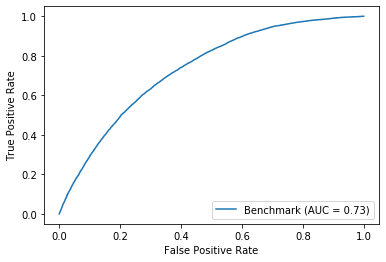

In [117]:
plot_roc_curve(lr, X_train, y_train, name='Benchmark')

We can see that the model is trainable and that a binary classification approach is at least practical, even if this initial benchmark model does not perform great. Specifically, the model does not do a great job at predicting negatives (i.e., which samples will NOT result in an offer completion), although it does a pretty good job at predicting positives. 

Next, we can try several classification approaches, including Random Forest and Decision Tree Classifier, along with another Logistic Regression where we tune the hyperparameters. To expedite the search for the best hyperparameters, we will use a Grid Search with cross-validation, which will test several sets of parameters on the estimator and return the best one. 

We will evaluate these models' performance using the Receiver Operator Characteristic area-under-the-curve, which plots the rate of the true positives to the rate of false positives predicted by the classifier. We will also look at several metrics, such as the precision and recall (f1 score), log-loss or cross entropy, and since this data set is not <i>overly</i> imbalanced, accuracy.  

Below are functions that will efficiently train these models using grid search with cross-validation, select the model with the best-performing parameters, and evaluate the model accoring to the chosen metrics.

In [118]:
def train(estimator, X, y,  params=None, cv=5, scoring_metric='roc_auc'):
    """Fit a model using grid search with cross validation.
        Returns the model and parameters with the best performance.
    """
    model = GridSearchCV(estimator, 
                         param_grid=params,
                         scoring=scoring_metric)
    model.fit(X, y)
    
    print(model.best_params_)
    return model.best_estimator_

In [119]:
def evaluate(model, X, y, name=None):
    """Evaluates model performance and prints a report of metrics and plots"""
    
    pred = model.predict(X)
    print('Confusion Matrix: \n', confusion_matrix(y, pred))
    print(classification_report(y, pred))
    
    print('Accuracy score: ',accuracy_score(y, pred))
    print('Log Loss: ', log_loss(y, pred))
    
    plot_roc_curve(model, X, y, name=name)

### Experimental Models

In [120]:
lr = LogisticRegression()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()

In [121]:
lr_clf = train(lr, X_train, y_train, params={'C':[1.0, 0.1, 0.01], 'class_weight':['balanced']})

{'C': 0.01, 'class_weight': 'balanced'}


In [122]:
rf_clf = train(dt, X_train, y_train, params={'max_depth': [1,3,5], 'class_weight':['balanced']})

{'class_weight': 'balanced', 'max_depth': 5}


In [123]:
dt_clf = train(rf, X_train, y_train, params={'max_depth': [1,3,5], 'class_weight':['balanced']})

{'class_weight': 'balanced', 'max_depth': 5}


In [307]:
dt_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Evaluation

Logistic Regression Model Performance:
Confusion Matrix: 
 [[4756 3044]
 [4525 7182]]
              precision    recall  f1-score   support

           0       0.51      0.61      0.56      7800
           1       0.70      0.61      0.65     11707

    accuracy                           0.61     19507
   macro avg       0.61      0.61      0.61     19507
weighted avg       0.63      0.61      0.62     19507

Accuracy score:  0.6119854411236992
Log Loss:  13.401672861416746
Random Forest Model Performance:
Confusion Matrix: 
 [[5678 2122]
 [4103 7604]]
              precision    recall  f1-score   support

           0       0.58      0.73      0.65      7800
           1       0.78      0.65      0.71     11707

    accuracy                           0.68     19507
   macro avg       0.68      0.69      0.68     19507
weighted avg       0.70      0.68      0.68     19507

Accuracy score:  0.6808837853078382
Log Loss:  11.021970564621206
Decision Tree Classifier Model Performance:
Conf

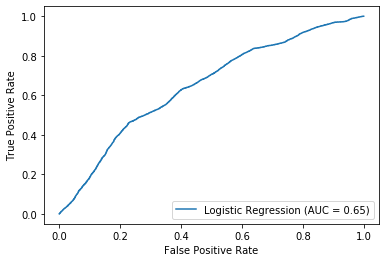

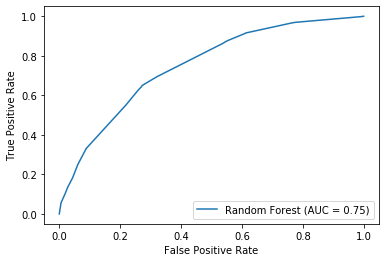

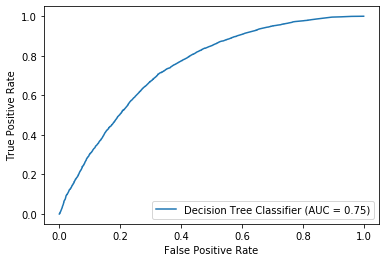

In [125]:
models = {lr_clf: 'Logistic Regression', 
          rf_clf: 'Random Forest', 
          dt_clf: 'Decision Tree Classifier'}

for k, v in models.items():
    print(f"{v} Model Performance:")
    evaluate(k, X_test, y_test, name=v)

It is clear that our Decision Tree Classifier performs the best, in terms of precision/recall/f1 score, accuracy, and log-loss, and is equal to the RandomForestClassifier in terms of ROC AUC. It also performs better than the benchmark Logistic Regression we ran earlier. We might try to improve performance by engineering some additional features, but first, let's check and see if removing the nulls from the original data set results in a better model than when we imputed the most frequent or median values.

In [202]:
# recreate the features without imputation of nulls
X2 = prep_data(data)

In [203]:
X2.isnull().sum()

person                    0
time                      0
offer_id                  0
gender                 8270
age                    8270
income                 8270
became_member_month    8270
became_member_year     8270
offer_reward              0
difficulty                0
duration                  0
offer_type                0
email                     0
mobile                    0
social                    0
web                       0
target                    0
dtype: int64

In [153]:
# remove nulls
X2.dropna(axis=0, inplace=True)

In [155]:
# prepare data for modeling
X2 = pd.get_dummies(X2)
y2 = X2.target
X2.drop(columns='target', inplace=True)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state = 0)

Let's fit another Decision Tree Classifier using the same parameters as before, so we can see which data set yields better results

In [156]:
dt2 = DecisionTreeClassifier(class_weight='balanced', max_depth= 5)
dt2.fit(X_train2, y_train2)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Decision Tree Classifier performance, nulls removed:
Confusion Matrix: 
 [[3914 2041]
 [3346 7725]]
              precision    recall  f1-score   support

           0       0.54      0.66      0.59      5955
           1       0.79      0.70      0.74     11071

    accuracy                           0.68     17026
   macro avg       0.67      0.68      0.67     17026
weighted avg       0.70      0.68      0.69     17026

Accuracy score:  0.6836015505697169
Log Loss:  10.928111148698395


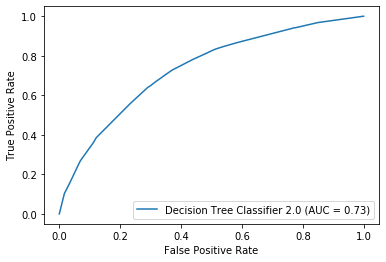

In [157]:
print('Decision Tree Classifier performance, nulls removed:')
evaluate(dt2, X_test2, y_test2, name='Decision Tree Classifier 2.0')

We can see that removing the null values results in a slightly worse performance for the Decision Tree Classifier. Another option is to drop these features altogether. First, we should see how important they are to the decision tree classifier models.

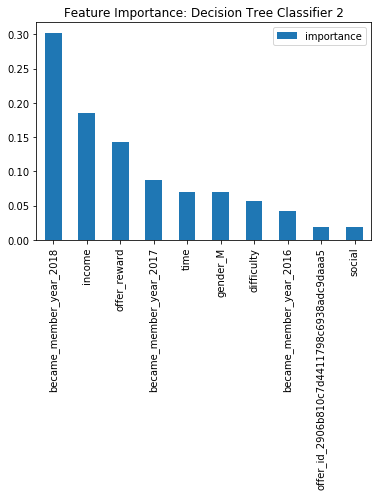

In [194]:
pd.DataFrame(dt2.feature_importances_,
             index = X2.columns,
             columns=['importance']).sort_values('importance',ascending=False) \
             .nlargest(10, 'importance').plot.bar(title='Feature Importance: Decision Tree Classifier 2')

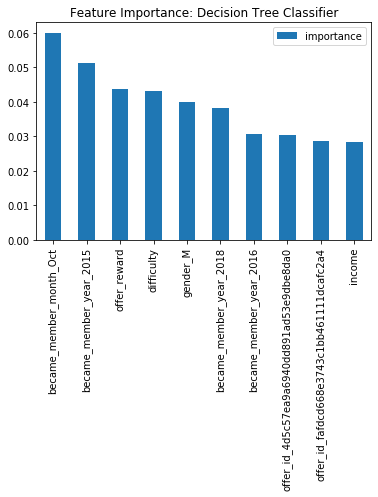

In [195]:
pd.DataFrame(dt_clf.feature_importances_,
             index = X.columns,
             columns=['importance']).sort_values('importance',ascending=False) \
             .nlargest(10, 'importance').plot.bar(title='Feature Importance: Decision Tree Classifier')

It looks like income and how long users have been a member are important features, but age and gender less so. Let's try a version where we drop the entire columns that have all these null values.

In [204]:
X3 = prep_data(data)

In [205]:
X3.isnull().sum()

person                    0
time                      0
offer_id                  0
gender                 8270
age                    8270
income                 8270
became_member_month    8270
became_member_year     8270
offer_reward              0
difficulty                0
duration                  0
offer_type                0
email                     0
mobile                    0
social                    0
web                       0
target                    0
dtype: int64

In [206]:
X3.drop(columns=['gender', 'age', 'income', 'became_member_month', 'became_member_year'], inplace=True)

In [207]:
X3.isnull().sum()

person          0
time            0
offer_id        0
offer_reward    0
difficulty      0
duration        0
offer_type      0
email           0
mobile          0
social          0
web             0
target          0
dtype: int64

In [208]:
# prepare 3rd Decision Tree model
X3 = pd.get_dummies(X3)
y3 = X3.target
X3.drop(columns='target', inplace=True)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.3, random_state = 0)

In [209]:
# fit the 3rd model
dt3 = DecisionTreeClassifier(class_weight='balanced', max_depth= 5)
dt3.fit(X_train3, y_train3)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Decision Tree Classifier performance, columns with nulls removed:
Confusion Matrix: 
 [[4697 3103]
 [4518 7189]]
              precision    recall  f1-score   support

           0       0.51      0.60      0.55      7800
           1       0.70      0.61      0.65     11707

    accuracy                           0.61     19507
   macro avg       0.60      0.61      0.60     19507
weighted avg       0.62      0.61      0.61     19507

Accuracy score:  0.6093197313784795
Log Loss:  13.49374563266726


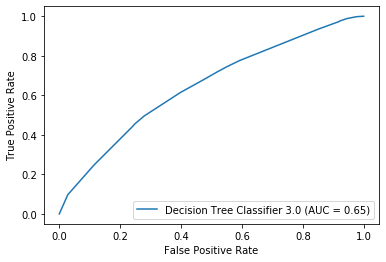

In [210]:
# evaluate performance
print('Decision Tree Classifier performance, columns with nulls removed:')
evaluate(dt3, X_test3, y_test3, name='Decision Tree Classifier 3.0')

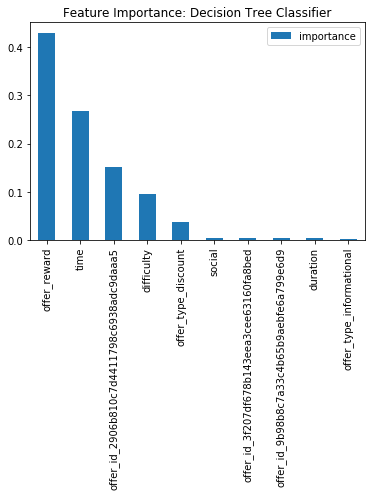

In [211]:
# check feature importance
pd.DataFrame(dt3.feature_importances_,
             index = X3.columns,
             columns=['importance']).sort_values('importance',ascending=False) \
             .nlargest(10, 'importance').plot.bar(title='Feature Importance: Decision Tree Classifier')

# Refinement

It looks like removing the entire columns with null values resulted in the worst Decision Tree Classifier yet. This is not surprising as several of the features we removed, such as income and 'became_member_on_X', were the most important in the original model. So we will continue with our original processed dataset, X, where we imputed mode values for gender, year, etc. and median values for missing age and income. To see if we can further improve model performance, we will engineer some additional features that could provide information about what kinds of offers appeal to which users.

To start, perhaps there is a correlation between how many offers a user receives and the likelihood they will redeem one.

In [228]:
# How many offers does a person receive?
cumulative_offers = data[data['event']=='offer received'].groupby(['person', 'offer_id']).count()['event'] \
.groupby(level=0).cumsum().reset_index()

In [229]:
cumulative_offers.rename(columns={'event':'cumulative_offers'}, inplace=True)

In [265]:
# need to recreate data set X because it is currently one-hot encoded
X = prep_data(data)

In [266]:
X['gender'].fillna(gender_mode, inplace=True)
X['became_member_month'].fillna(became_member_month_mode, inplace=True)
X['became_member_year'].fillna(became_member_year_mode, inplace=True)
X['age'].fillna(age_median, inplace=True)
X['income'].fillna(income_median, inplace=True)

In [230]:
cumulative_offers

,person,offer_id,cumulative_offers
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,2
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,4
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,5
...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,4
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,4
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,5


In [267]:
X = X.merge(cumulative_offers, how='left', on=['person', 'offer_id'])

The 'became_member_year' columns also seem to be important features. Perhaps there is additional predictive information in how long a user has been a member. We can engineer a new feature, "membership_years", to quantify membership time more linearly than the categorical variable.

In [238]:
# find the max date to back-calculate membership years
pd.to_datetime(profile['became_member_on']).max()

Timestamp('2018-07-26 00:00:00')

Looks like the latest membership date is 2018, so "membership_years" should start at 0 from 2018.

In [268]:
X['membership_years'] = 2018 - X['became_member_year'].astype(int)

In [269]:
X.isnull().sum()

person                    0
time                      0
offer_id                  0
gender                    0
age                       0
income                    0
became_member_month       0
became_member_year        0
offer_reward              0
difficulty                0
duration                  0
offer_type                0
email                     0
mobile                    0
social                    0
web                       0
target                    0
cumulative_offers      1733
membership_years          0
dtype: int64

In [270]:
X['cumulative_offers'].fillna(0, inplace=True)

Now we have two new features that should provide more information about what types of offers are most successful, engineered from looking at the feature importances of previous model experiments. Now we are ready to train our final model and assess performance.

In [272]:
# prepare data for modeling
X = pd.get_dummies(X)
y = X.target
X.drop(columns='target', inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [250]:
dt_final = DecisionTreeClassifier(class_weight='balanced', max_depth=5)

In [273]:
# fit final model
dt_final.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Confusion Matrix: 
 [[5458 2342]
 [3203 8504]]
              precision    recall  f1-score   support

           0       0.63      0.70      0.66      7800
           1       0.78      0.73      0.75     11707

    accuracy                           0.72     19507
   macro avg       0.71      0.71      0.71     19507
weighted avg       0.72      0.72      0.72     19507

Accuracy score:  0.71574306659148
Log Loss:  9.817982660940238


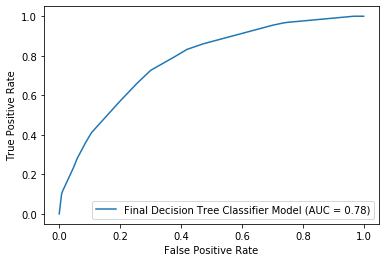

In [274]:
# evaluate final model performance on testing data
evaluate(dt_final, X_test, y_test, name='Final Decision Tree Classifier Model')

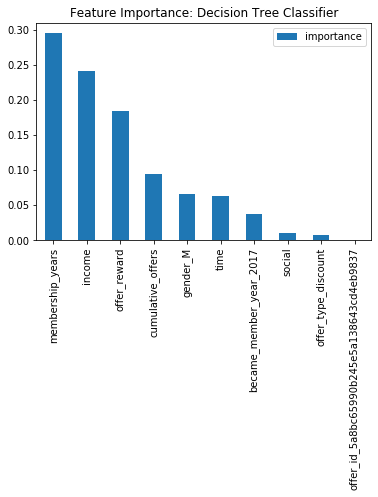

In [275]:
# evaluate feature importances of final model
pd.DataFrame(dt_final.feature_importances_,
             index = X.columns,
             columns=['importance']).sort_values('importance',ascending=False) \
             .nlargest(10, 'importance').plot.bar(title='Feature Importance: Decision Tree Classifier')

#### Our model has improved!

# Conclusions
Our final model has shown an improvement in nearly all evaluation metrics as compared to both the original benchmark model and our previous best model (Decision Tree Classifer). The results of these models are summarized below.

In [309]:
# copy results from evaluation of models above
lr_results = pd.DataFrame([[.73, .69, 10.7]], 
                          columns=['AUC', 'Accuracy', 'Log Loss'],
                          index=['Benchmark (Logistic Regression)'])

dt_clf_results = pd.DataFrame([[.75, .69, 10.6]],
                              columns=['AUC', 'Accuracy', 'Log Loss'],
                              index=['Decision Tree Classifier (Initial)'])

dt_final_results = pd.DataFrame([[.78, .72, 9.8]],
                              columns=['AUC', 'Accuracy', 'Log Loss'],
                              index=['Decision Tree Classifier (Final)'])

pd.concat([lr_results, dt_clf_results, dt_final_results], axis=0)

,AUC,Accuracy,Log Loss
Benchmark (Logistic Regression),0.73,0.69,10.7
Decision Tree Classifier (Initial),0.75,0.69,10.6
Decision Tree Classifier (Final),0.78,0.72,9.8


We can see that our refined Decision Tree Classifier exceeds the AUC of the benchmark by .05 and the original Decision Tree Classifier by .03. The accuracy metric improves over both prior models by 3%. Additionally, the log loss has decreased to 9.8 from around 10.6. This is a marked improvement with the addition of only two new features.

Looking at the feature importance chart above, we can see that in particular, the new "membership_years" feature we developed made a large difference in predictive power, being the most important feature in the new model. The "cumulative_offers" feature is the 4th most important feature in the new model, so overall this was effort well-spent.

Lastly, we can use the model interpretation library eli5 to dive more deeply into the model features and explore how the decision tree is making predictions

In [310]:
!pip install eli5

     |████████████████████████████████| 106 kB 3.0 MB/s eta 0:00:01


In [330]:
from eli5.sklearn import explain_weights
from eli5.formatters.html import format_as_html
from IPython.display import HTML, display

In [331]:
explanation = explain_weights.explain_decision_tree(dt_final, feature_names=X.columns.tolist())
html_rep = format_as_html(explanation)
display(HTML(data=html_rep))

Weight,Feature
0.2946,membership_years
0.2408,income
0.1845,offer_reward
0.0945,cumulative_offers
0.0660,gender_M
0.0638,time
0.0373,became_member_year_2017
0.0106,social
0.0073,offer_type_discount
0.0007,offer_id_5a8bc65990b245e5a138643cd4eb9837


We can see that the feature importances found by eli5 match closely what is found in the DecisionTree().feature_importances_ attribute that we plotted above. Here we get a little more detail as to how much weight is assigned to each feature and what values are most important in the decision tree. 

We can see in both feature importance charts that the most effective offer is a discount, and the most effective medium for offers is social (rather than email, mobile, or web). This is information perhaps Starbucks would find valuable in targeting future offers.

The model also thinks that male users are more likely to complete an offer than female users. While males did complete more offers than females overall, we know from our EDA that males outnumber females, and that they received and viewed more offers cumulatively. On the other hand, females completed a higher <i> proportion </i> of the offers they received, which the model does not seem to pick up on.

The eli5 library also displays the decision tree. It is a little difficult to interpret in plain text, but sklearn has the ability to visualize the decision tree using matplotlib.

In [332]:
from sklearn.tree import plot_tree

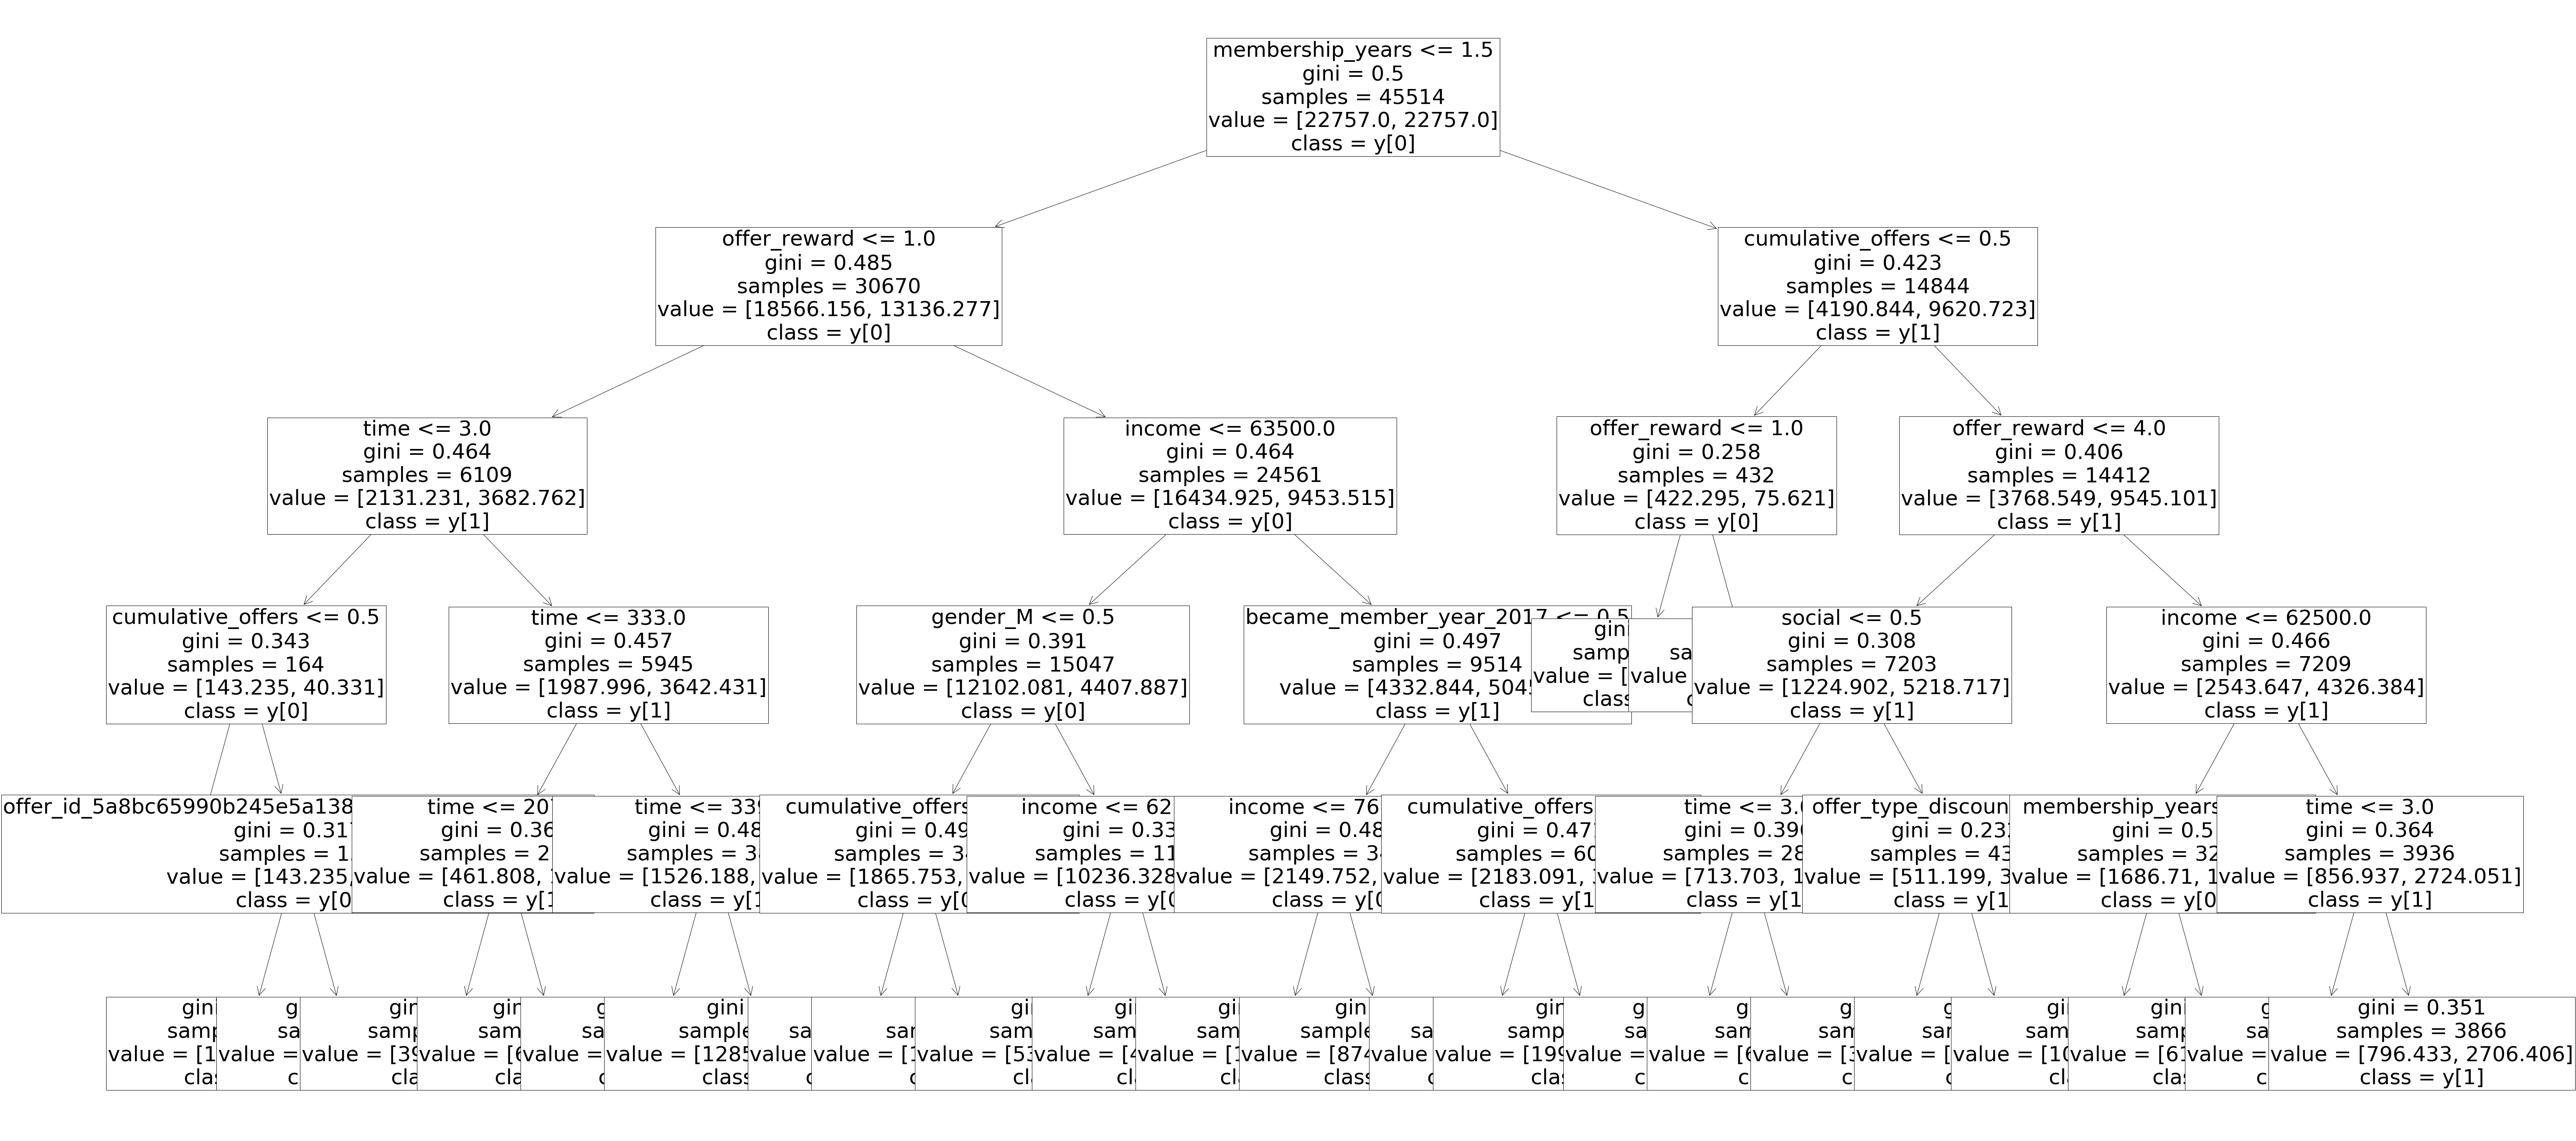

In [346]:
plt.figure(figsize=(100,50))
plot_tree(dt_final, fontsize=50, feature_names = X.columns.tolist(), class_names=True)
plt.show()

This provides the final piece of the puzzle in interpreting the model. Like in the eli5 rendering above, we can see the decision splits for each feature. Now, however, we know how each split is classified. 

Looking at the first node, membership_years <= 1.5 years is the first decision split. Users with less than 1.5 years as a member are less likely to complete an offer if the offer reward is less than one dollar. (offer_reward <= 1.0 yields a class of 0). 

We can also see the role that income plays. Here the split is 63500 dollars, below which a user is less likely to complete an offer unless the reward amount is higher. 

In completing this model and interpreting the results, we now have a lot of valuable information for Starbucks in what kinds of offers are most successful (discount), what kinds of customers to target (Male members of at least 1.5 years with income greater than 63500), and by what medium (social media). It will be interesting to see how targeting promotional offers using this model improves sales and customer engagement.